In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
 
# setting path
sys.path.append('..')

In [6]:
import skimage
import torch
import numpy as np
import glob
import os
import torchmetrics
import scipy
from training.segmentation_module import BinarySegmentation
from utils.config_utils import read_transforms

In [7]:
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0) 

In [8]:
model_id = '2ixkh869'

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Visualization Helpers

In [13]:
def visualize_mask(img, mask, color=(255, 0, 0), alpha=0.5):
  # credits: https://stackoverflow.com/questions/9193603/applying-a-coloured-overlay-to-an-image-in-either-pil-or-imagemagik

  img_color = skimage.color.gray2rgb(img)

  col_mask = np.ones((mask.shape[0], mask.shape[1], 3)) * (255, 0 ,0)
  col_mask[mask == 0] = 0

  img_hsv = skimage.color.rgb2hsv(img_color)
  color_mask_hsv = skimage.color.rgb2hsv(col_mask)

  # Replace the hue and saturation of the original image
  # with that of the color mask
  img_hsv[..., 0] = color_mask_hsv[..., 0]
  img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

  return skimage.color.hsv2rgb(img_hsv)

In [14]:
def crop(image, mask=None, padding=10):
    meansY, meansX = np.mean(image, axis=1), np.mean(image, axis=0)    
    selected_indices = np.asarray(meansX > np.round(np.min(meansX))).nonzero()[0]
    minX = selected_indices[0] - padding
    maxX = selected_indices[-1] + padding
    selected_indices = np.asarray(meansY > np.round(np.min(meansY))).nonzero()[0]
    minY = selected_indices[0] - padding
    maxY = selected_indices[-1] + padding
    if mask is not None:
        return image[minY:maxY, minX:maxX], mask[minY:maxY, minX:maxX]
    return image[minY:maxY, minX:maxX]

In [15]:
model_path = "../trunk-segmentation/{}/checkpoints/last.ckpt".format(model_id)
model = BinarySegmentation.load_from_checkpoint(model_path).to(device)
config = model.config
general_transforms = read_transforms(config['transforms']['general'])

## Setup Evaluation

In [16]:
# # Predictions by machine
# models = {}  # should be a float tensor
# # Segmentation by human (ground truth)
# manual_segmentation = None  # should be a long tensor
# # Selected (high quality) regions used for evaluation
# evaluation_mask = None  # should be a boolean tensor

In [126]:
axes_files = sorted(glob.glob(os.path.join('..', "exports", model_id, "*.tiff")))
models = {}
for a in axes_files:
    model_name = os.path.splitext(os.path.basename(a))[0]
    print("Loading model", model_name, "from", a)
    multi_img = skimage.io.MultiImage(a)
    models[model_name] = multi_img[0]

Loading model 0 from ..\exports\2ixkh869\0.tiff
Loading model 1 from ..\exports\2ixkh869\1.tiff
Loading model 2 from ..\exports\2ixkh869\2.tiff


In [18]:
models['0'].shape

(1445, 2150, 2150)

### Visualize Data

In [29]:
data_path = "../data/scan.tif"
image_data = general_transforms(image=skimage.io.MultiImage(data_path)[0])['image']

In [30]:
image_data.shape

(1445, 2150, 2150)

### Load everything else

In [148]:
def abs_error(y_hat, target):
    return np.sum(y_hat != target) / len(target)

In [2]:
multi_img = skimage.io.MultiImage("../data/segmentation.tif")
manual_segmentation = multi_img[0]

In [3]:
multi_img = skimage.io.MultiImage("../data/validation_mask_extended.tiff")
evaluation_mask = multi_img[0]

In [10]:
evaluation_mask = evaluation_mask.astype(bool)

In [150]:
target = manual_segmentation[evaluation_mask]

In [151]:
results = []

jaccard_fn = scipy.spatial.distance.jaccard
dice_fn = scipy.spatial.distance.dice
for model, predictions in models.items():
    y_hat = predictions[evaluation_mask]
    jaccard_index = jaccard_fn(y_hat, target)
    dice_score = 2 * dice_fn(y_hat, target)
    abs_err = abs_error(y_hat, target)
    results.append((model, jaccard_index, dice_score, abs_err))

In [152]:
results

[('0', 0.4737801354909511, 0.6208543690307107, 0.0957516508905326),
 ('1', 0.43153812073380443, 0.5502691859309955, 0.09007600444521771),
 ('2', 0.4315707738919931, 0.5503222800341695, 0.08886046624628324)]

In [143]:
results

[('0', 0.5820308464906356, 0.7461414449429496),
 ('1', 0.49005655060529524, 0.5905913312634659),
 ('2', 0.4921585800198517, 0.5971657801037172)]

## Actual Majority Voting

In [155]:
super_model_pre = models['0'][evaluation_mask] + models['1'][evaluation_mask] + models['2'][evaluation_mask]

In [156]:
super_model_pre /= 3

In [158]:
extended_models = {}
extended_models['All Agree'] = super_model_pre == 1
extended_models['Majority Voting'] = super_model_pre > 0.66
extended_models['Merge'] = super_model_pre > 0

In [159]:
for model, y_hat in extended_models.items():
    jaccard_index = jaccard_fn(y_hat, target)
    dice_score = 2 * dice_fn(y_hat, target)
    abs_err = abs_error(y_hat, target)
    results.append((model, jaccard_index, dice_score, abs_err))

In [160]:
results

[('0', 0.4737801354909511, 0.6208543690307107, 0.0957516508905326),
 ('1', 0.43153812073380443, 0.5502691859309955, 0.09007600444521771),
 ('2', 0.4315707738919931, 0.5503222800341695, 0.08886046624628324),
 ('All Agree', 0.5051432846366452, 0.6758417438207246, 0.09525242598226615),
 ('Majority Voting',
  0.4300566816585546,
  0.547862686040009,
  0.0875281548741436),
 ('Merge', 0.4091292850215254, 0.5143463653827598, 0.0919075407256238)]

In [33]:
results  # TODO: find more metrics (comparing quantitative with qualitative it seems there is a discrepancy)

[('0', 0.5320657717268255, 0.6327111116738575),
 ('1', 0.4852755856899538, 0.565482667751459),
 ('2', 0.47989010460769344, 0.559883475757238),
 ('All Agree', 0.5518138006386204, 0.7620757619178515),
 ('Majority Voting', 0.4359628779314819, 0.5574840542849763),
 ('Merge', 0.4164239330857005, 0.5259285509374103)]

### Visualize New Model

In [ ]:
pylab.rcParams['figure.figsize'] = (15.0, 12.0)
super_model_pred = ((models['0'][key] + models['1'][key] + models['2'][key]) / 3) == 1  # TODO: write a function to compute the combined models
img_cropped, mask_cropped = crop(image_data[key], super_model_pred)
skimage.io.imshow(visualize_mask(img_cropped, mask_cropped))

In [ ]:
pylab.rcParams['figure.figsize'] = (15.0, 12.0)
super_model_pred = ((models['0'][key] + models['1'][key] + models['2'][key]) / 3) > 0  # TODO: write a function to compute the combined models
img_cropped, mask_cropped = crop(image_data[key], super_model_pred)
skimage.io.imshow(visualize_mask(img_cropped, mask_cropped))

## Analyse performance of regions

1. Extract regions from evaluation mask
2. Compute scores for each region
3. Calculate average over these scores
4. Analyse which regions perform better or worse

In [167]:
from utils.dataset_utils import extract_masked_regions, cache_exists, load_cached, save_cache
from functools import reduce
import pandas as pd

In [60]:
total_size = manual_segmentation.shape[0] * manual_segmentation.shape[1] * manual_segmentation.shape[2]
indices = np.arange(0, total_size)
indices = np.reshape(a, manual_segmentation.shape)

In [65]:
cache_path = 'eval_mask'
if cache_exists(cache_path):
    eval_imgs, eval_indices = load_cached(cache_path)
else:
    print('Cache does not exist')
    eval_imgs, eval_indices = extract_masked_regions(evaluation_mask, image_data, indices, config['patch_size'])
    save_cache(cache_path, eval_imgs, eval_indices)

Finding masks in axis 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2150/2150 [02:02<00:00, 17.62it/s]


In [204]:
cache = {}
def select_region(region, data, cache_i=None, reshape=True):
    if cache_i is not None and cache_i in cache:
        mask_ = cache[cache_i]
    else:
        total_size = reduce((lambda x, y: x * y), data.shape)
        mask_ = np.zeros(total_size, dtype=bool)
        mask_[region.flatten()] = 1
        mask_ = mask_.reshape(data.shape)
        if cache_i is not None:
            cache[cache_i] = mask_
    return data[mask_].reshape(region.shape) if reshape else data[mask_]

In [205]:
mask = select_region(eval_indices[1], manual_segmentatione_data)

In [209]:
results_detailed = []
for i, region in enumerate(eval_indices):
    cache = {}  # save some memory
    target = select_region(region, manual_segmentation, cache_i=i, reshape=False)
    for model, predictions in models.items():
        y_hat = select_region(region, predictions, cache_i=i, reshape=False)
        jaccard_index = jaccard_fn(y_hat, target)
        dice_score = 2 * dice_fn(y_hat, target)
        abs_err = abs_error(y_hat, target)
        results_detailed.append((i, model, jaccard_index, dice_score, abs_err))
    
    y_0 = select_region(region, models['0'], cache_i=i, reshape=False)
    y_1 = select_region(region, models['1'], cache_i=i, reshape=False)
    y_2 = select_region(region, models['2'], cache_i=i, reshape=False)
    
    extended_models_detailed = {}
    super_model_pre = y_0 + y_1 + y_2
    super_model_pre /= 3
    extended_models_detailed['All Agree'] = super_model_pre == 1
    extended_models_detailed['Majority Voting'] = super_model_pre > 0.66
    extended_models_detailed['Merge'] = super_model_pre > 0
    
    for model, y_hat in extended_models_detailed.items():
        jaccard_index = jaccard_fn(y_hat, target)
        dice_score = 2 * dice_fn(y_hat, target)
        abs_err = abs_error(y_hat, target)
        results_detailed.append((i, model, jaccard_index, dice_score, abs_err))

C:\Users\lab\anaconda3\envs\trunkSeg\lib\site-packages\scipy\spatial\distance.py:1415: RuntimeWarning: invalid value encountered in divide
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))


In [210]:
df_results = pd.DataFrame.from_records(results, columns=['model','jaccard','dice', 'abs error'])

In [211]:
df = pd.DataFrame.from_records(results_detailed, columns=['region','model','jaccard','dice', 'abs error'])

In [212]:
df.groupby(['model']).mean()

,region,jaccard,dice,abs error
model,,,,
0,5.5,0.470486,0.720793,0.116159
1,5.5,0.441517,0.681204,0.108038
2,5.5,0.421294,0.610819,0.106184
All Agree,5.5,0.502022,0.792568,0.117109
Majority Voting,5.5,0.436166,0.664136,0.105074
Merge,5.5,0.401096,0.573698,0.108198


In [213]:
df_results

,model,jaccard,dice,abs error
0,0,0.473780,0.620854,0.095752
1,1,0.431538,0.550269,0.090076
2,2,0.431571,0.550322,0.088860
3,All Agree,0.505143,0.675842,0.095252
4,Majority Voting,0.430057,0.547863,0.087528
5,Merge,0.409129,0.514346,0.091908


<Axes: xlabel='region'>

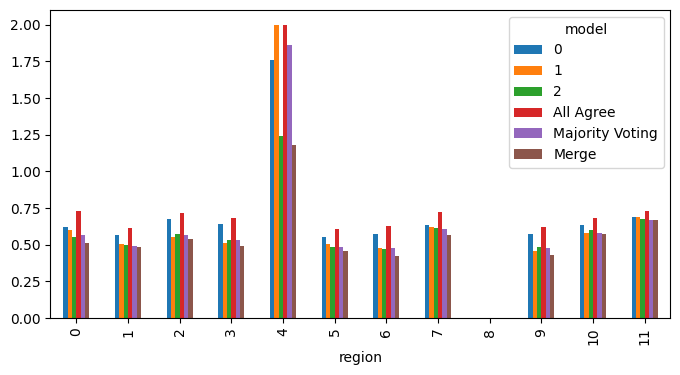

In [218]:
pylab.rcParams['figure.figsize'] = (8.0, 4.0) 
df.set_index(['model', 'region'], inplace=False).dice.unstack(0).plot.bar()

## Build the final model
It seems like the "merged" model performs the best. Hence, we merge the whole prediction and save it as a new output.

In [220]:
combined_model = models['0'] + models['1'] + models['2']

In [221]:
combined_model /= 3

In [222]:
combined_model = combined_model > 0

In [223]:
filename = '../exports/{}/combined.tiff'.format(model_id)

In [137]:
import torchio as tio

In [224]:
model_tensor = torch.from_numpy(combined_model)

In [234]:
s_image = tio.ScalarImage(tensor=model_tensor.permute([2, 1, 0]).unsqueeze(0).float())

In [235]:
s_image.save(filename)

In [236]:
config['name']

'Baseline with more data'